# PELS tutorrial hands on

## Let us understand the system

* We query the system topology using LIKWID tool.
* Note that only 1 NUMA domain (16 cores) of CPU is available.
* Attached is also one A100 GPU.
* Watch out for the available cores.

In [1]:
!likwid-topology

--------------------------------------------------------------------------------
CPU name:	AMD EPYC 7713 64-Core Processor
CPU type:	AMD K19 (Zen3) architecture
CPU stepping:	1
********************************************************************************
Hardware Thread Topology
********************************************************************************
Sockets:		2
Cores per socket:	64
Threads per core:	1
--------------------------------------------------------------------------------
HWThread        Thread        Core        Die        Socket        Available
0               0             0           0          0                              
1               0             1           0          0                              
2               0             2           0          0                              
3               0             3           0          0                              
4               0             4           0          0                              


## CPU main memory bandwidth

* Main memory bandwidth is the most important hardware characteristic relevant to SpMV like kernels.
* Let us measure the bandwidth using LIKWID tool.
* Note that bandwidth of only 1 NUMA domain (16 cores) is measured.

In [2]:
!likwid-bench -t load_avx -w N:4GB:16

Allocate: Process running on hwthread 88 (Domain N) - Vector length 500000000/4000000000 Offset 0 Alignment 512
Initialization: First thread in domain initializes the whole stream
--------------------------------------------------------------------------------
LIKWID MICRO BENCHMARK
Test: load_avx
--------------------------------------------------------------------------------
Using 1 work groups
Using 16 threads
--------------------------------------------------------------------------------
Running without Marker API. Activate Marker API with -m on commandline.
--------------------------------------------------------------------------------
Group: 0 Thread 8 Global Thread 8 running on hwthread 88 - Vector length 31250000 Offset 250000000
Group: 0 Thread 7 Global Thread 7 running on hwthread 95 - Vector length 31250000 Offset 218750000
Group: 0 Thread 6 Global Thread 6 running on hwthread 94 - Vector length 31250000 Offset 187500000
Group: 0 Thread 9 Global Thread 9 running on hwthrea

## Let us set up our environment

In [7]:
import sys
#On cluster we might not have internet to download packages
#so we set path to pre-installed Python packages
sys.path.insert(0, "/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages") 

import os
os.environ["USE_RACE"]="1" #Compile RACE too
os.environ["OMP_SCHEDULE"]="static"
os.environ["OMP_NUM_THREADS"]="16"

## SpMV benchmarking

In [8]:
from kernels import *
import numpy as np
import numba
import gc
from numpy.linalg import norm
from scipy.sparse import *
from scipy.io import mmread
from sellcs import sellcs_matrix
from matrix_generator import create_matrix
import time
import matplotlib.pyplot as plt 


def spmv_bench(matrix, mat_fmt='CRS', arrow=False):
    ## **Note:** The Python garbage collector (gc)
    ## can kill the performance of the C kernels
    ## for some obscure reason (possibly a conflict
    ## between Numba/LLVM and other compilers like GCC).
    ## For the pure Python/numba/cuda kernels, this is not
    ## the case, but if you are facing obvious performnace
    ## problems with the C kernels, you may want to disalbe
    ## garbage collection:
    gc.disable()

    rand_seed=1
    if rand_seed is not None:
        np.random.seed(rand_seed)

    A = create_matrix(matrix, arrow=arrow)
    #plt.spy(A)
    N = A.shape[0]
    #print "nrows = %d, nnz = %d, nnzr = %.2f" % (N, A.nnz, A.nnz/N)
    print("nnz = ", A.nnz, "nrows =", N, "nnzr =", round(A.nnz/N,2))
    if 'SELL' in mat_fmt:
        C_=int(mat_fmt.split('-')[1])
        if C_ > 256:
            print('C greater than 256. Setting to maximum possible value 256')
            C_ = 256
        sigma_=int(mat_fmt.split('-')[2])
        print('Matrix format: SELL-%d-%d'%(C_,sigma_))
        A = sellcs_matrix(A_csr=A, C=C_, sigma=sigma_)
    else:
        print('Matrix format: CSR')
    
    x=np.random.rand(N)
    y=np.random.rand(N)

    if available_gpus()>0:
        type = 'gpu'
    else:
        type = 'cpu'

    #Transfer to device in case of GPU
    if type=='gpu':
        y = to_device(y)
        A = to_device(A)
        x = to_device(x)
        
    #warm-up, determine iterations for 1 sec
    iter=10
    start = perf_counter()
    for it in range(1, iter+1):
        spmv(A,x,y)
    end = perf_counter()
    iter=int(iter/(end-start))
    iter=max(1, iter)

    reset_counters()
    start = perf_counter()
    #Run SpMV for iter times
    for it in range(1, iter+1):
        spmv(A,x,y)
    end = perf_counter()
    
    print("Performance GFlop/s = ", 2*iter*A.nnz*1e-9/(end-start))
    perf_report(type)

    gc.enable()

## SpMV on CPU
Let's run SpMV on CPU.
* The matrix used is a simple 3D Laplacian of dimension 240x240x240.
* Observe the achieved performance.
* Benchmark also outputs bandwidth estimate based on minimum memory transfer assumption. 
* Does it match roofline predictions?

In [9]:
os.environ["USE_CPU"]="True"
spmv_bench('Laplace240x240x240')

nnz =  96422400 nrows = 13824000 nnzr = 6.97
Matrix format: CSR
Performance GFlop/s =  4.156301436643446
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
Number of threads: 8
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
    spmv	   21	    32.1 GB/s	   0.974 s 	 0.04638 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    0.974 s 
--------	-----	---------------	---------------


/home/hpc/unrz/unrz002h/installkit/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


# Sparse matrix data formats on CPU
Does changing from CRS to SELL-C-sigma data storage format change performance on CPU? Why?

In [14]:
os.environ["USE_CPU"]="True"
spmv_bench('Laplace240x240x240', mat_fmt='SELL-32-1')

nnz =  96422400 nrows = 13824000 nnzr = 6.97
Matrix format: SELL-32-1
Performance GFlop/s =  4.153902863204181
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
Number of threads: 8
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
    spmv	   21	   32.08 GB/s	  0.9748 s 	 0.04642 s 	
--------	-----	---------------	---------------
   Total	     	               	               	   0.9748 s 
--------	-----	---------------	---------------


## SpMV  on GPU
* Observe the performance of SpMV on GPU.
* Do we hit roofline limit?

In [11]:
os.environ["USE_CPU"]="False"
spmv_bench('Laplace240x240x240')

nnz =  96422400 nrows = 13824000 nnzr = 6.97
Matrix format: CSR
Performance GFlop/s =  47.99670305248711
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
    spmv	   74	     371 GB/s	   0.297 s 	0.004013 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    0.297 s 
--------	-----	---------------	---------------


## Sparse matrix data formats on GPU
* Does SELL-C-sigma improve GPU performance?
* Try increasing the chunk size (C) parameter (maximum possible value is 256) and observe what hapens.

In [12]:
os.environ["USE_CPU"]="False"
spmv_bench('Laplace240x240x240', mat_fmt='SELL-8-1')

nnz =  96422400 nrows = 13824000 nnzr = 6.97
Matrix format: SELL-8-1
Performance GFlop/s =  40.22269451318154
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
    spmv	   63	   310.7 GB/s	  0.3019 s 	0.004792 s 	
--------	-----	---------------	---------------
   Total	     	               	               	   0.3019 s 
--------	-----	---------------	---------------


## Can we use matrix format blindly?
* Try using SELL-C-sigma matrix on a modified Laplacian matrix with an arrow
* Is the performance similar to a plain Laplacian matrix? Why?
* Hint: Observe the sparsity pattern of the two matrices. See next cell.

In [15]:
os.environ["USE_CPU"]="False"
spmv_bench('Laplace240x240x240', mat_fmt='SELL-8-1', arrow=True)

nnz =  124070392 nrows = 13824000 nnzr = 8.97
Matrix format: SELL-8-1
Performance GFlop/s =  0.07885800046856334
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
    spmv	    1	  0.5786 GB/s	   3.147 s 	   3.147 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    3.147 s 
--------	-----	---------------	---------------


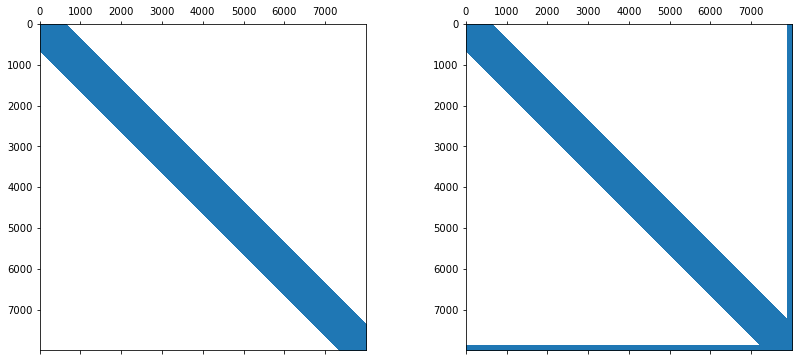

In [16]:
plt.subplots(1,2, figsize=(14,6))

plt.subplot(1, 2, 1)
A = create_matrix('Laplace20x20x20', arrow=False)
plt.spy(A)
plt.subplot(1, 2, 2)
A_arrow = create_matrix('Laplace20x20x20', arrow=True)
plt.spy(A_arrow)

# PCG solver
* PCG solver is implemented using the cg_solve function. Have a look.
* Notice the kernels used for implementing PCG solver.

In [17]:
from kernels import *
import numpy as np
import numba
import gc
from numpy.linalg import norm
from scipy.sparse import *
from scipy.io import mmread
from sellcs import sellcs_matrix
from poly_op import *


from matrix_generator import create_matrix

def cg_solve(A, b, x0, tol, maxit, verbose=False, x_ex=None):
    '''
    x, tol, iter = cg_solve(A, b, x0, tol, maxit)
    Where A is an spd scipy.sparse.csr_matrix, b and x0 are numpy.array's of size A.shpae[0],
    tol is the convergence tolerance and maxit the maximum number of iterations.
    '''
    x = clone(b)
    r = clone(b)
    p = clone(b)
    q = clone(b)

    err_norms=[]
    res_norms=[]
    
    if x_ex is not None:
        print('PerfWarning: providing the exact solution x_ex results in additional operations to calculate and print the error norm.')
        err = clone(b)

    tol2 = tol*tol


    axpby(1.0,x0,0.0,x)

    #r = A*x
    if hasattr(A, 'apply'):
        A.apply(x, r)
    else:
        spmv(A, x, r)
    #r = b - r
    axpby(1.0, b, -1.0, r)
    #p = r
    axpby(1.0, r, 0.0, p)

    # rho = <r, r>
    rho = dot(r,r);
    rho_old = 1.0
    if verbose:
        print('%d\t%e'%(0, np.sqrt(rho)))


    for iter in range(maxit+1):

        # check stop criteria
        if rho < tol2:
            break;

        # q = A*p
        if hasattr(A, 'apply'):
            A.apply(p, q)
        else:
            spmv(A, p, q)

        pq = dot(p,q)
        alpha = rho / pq
        # x = x+alpha*p
        axpby(alpha, p, 1.0, x)
        # r = r - alpha*q
        axpby(-alpha, q, 1.0, r)

        rho_old = rho
        rho = dot(r, r)

        curr_res_norm=np.sqrt(rho)
        res_norms.append(curr_res_norm)
        if x_ex is not None:
            if hasattr(A, 'unprec_sol'):
                A.unprec_sol(x, err)
            else:
                axpby(1.0, x, 0.0, err)
            axpby(-1.0, x_ex, 1.0, err)
            curr_err_norm=np.sqrt(dot(err, err))
            err_norms.append(curr_err_norm)    
            if verbose:
                print('%d\t%e\t%e'%(iter+1, curr_res_norm, curr_err_norm))
        else:   
            if verbose:
                print('%d\t%e'%(iter+1, curr_res_norm))

        beta = rho / rho_old
        # p = r+beta*p
        axpby (1.0, r, beta, p)

    iter_count = iter
    final_residual = np.sqrt(rho)

    return x, final_residual, iter_count, res_norms, err_norms




def bench(matrix, maxit, mat_fmt='CSR', poly_k=0, tol=1e-3, use_RACE=False, cache_size=60, rand_seed=1, print_perf=False):
    ## **Note:** The Python garbage collector (gc)
    ## can kill the performance of the C kernels
    ## for some obscure reason (possibly a conflict
    ## between Numba/LLVM and other compilers like GCC).
    ## For the pure Python/numba/cuda kernels, this is not
    ## the case, but if you are facing obvious performnace
    ## problems with the C kernels, you may want to disalbe
    ## garbage collection:
    gc.disable()

    if rand_seed is not None:
        np.random.seed(rand_seed)

    #if args.matfile != 'None':
    #    if args.matgen!='None':
    #        print('got both -matfile and -matgen, the latter will be ignored.')
    #    if not args.matfile.endswith(('.mm','.mtx','.mm.gz','.mtx.gz')):
    #        raise(ValueError('Expecting MatrixMarket file with extension .mm[.gz] or .mtx[.gz]'))
    #    A = csr_matrix(mmread(args.matfile))
    A = create_matrix(matrix)
    N = A.shape[0]

    x_ex=np.random.rand(N)

    b=A*x_ex

    x0 = np.zeros(N,dtype='float64')

    print('norm of rhs: %e'%(norm(b)))
    print('rel. residual of given solution: %e'%(norm(A*x_ex-b)/norm(b)))

    sigma=1

    A_csr = A # we may need it for creating the preconditioner
              # in case the user wants a SELL-C-sigma matrix.

    print("nnz = ", A.nnz, "nrows =", N, "nnzr =", A.nnz/N)
    if 'SELL' in mat_fmt:
        C_=int(mat_fmt.split('-')[1])
        if C_ > 256:
            print('C greater than 256. Setting to maximum possible value 256')
            C_ = 256
        sigma_=int(mat_fmt.split('-')[2])
        print('Matrix format: SELL-%d-%d'%(C_,sigma_))
        A = sellcs_matrix(A_csr=A_csr, C=C_, sigma=sigma_)
        b = b[A.permute]
        A_csr = A_csr[A.permute[:,None], A.permute]
    else:
        print('Matrix format: CSR')

    if available_gpus()>0:
        type = 'gpu'
    else:
        type = 'cpu'

    print('Will run on '+type)
    
    numa=True
    
    if type=='gpu':
        x0 = to_device(x0)
        b  = to_device(b)
        A  = to_device(A)
        x_ex = to_device(x_ex)

    #Just run all the kernels one time. Just for catching any errors
    compile_all() 

    A_prec = A
    b_prec = b

    # we want to make sure what we measure during CG in total
    # is consistent with the sum of the kernel calls and their
    # runtime as predicted by the roofline model, so reset all
    # counters and timers:
    reset_counters()

    t0 = perf_counter()

    t0_pre = perf_counter()
    if poly_k>0:
        # building preconditioners typically requires a certain format,
        # in our case, the poly_op class uses scipy functions tril and triu,
        # which are not implemented by the sellcs_matrix class.
        print("calling poly_op ", poly_k)
        A_prec = poly_op(A_csr, poly_k, use_RACE, cache_size)
        if A_prec.mpkHandle != None:
            b = b[A_prec.permute]
            #A_csr = A_csr[A_prec.permute[:,None], A_prec.permute]
            A_csr = permute_csr(A_csr, A_prec.permute)
        if 'SELL' in mat_fmt:
            # note: If A was originally sorted by row-length (sigma>1), use the same
            # sorting for L and U to avoid intermittent permutation by setting sigma=1.
            # There still seems to be some kind of bug, though, because the number of
            # iterations will increase with poly_k>0 and sigma>1. Hence this warning.
            C_=int(mat_fmt.split('-')[1])
            sigma_=int(mat_fmt.split('-')[2])
            A_prec.L = to_device(sellcs_matrix(A_csr=A_prec.L, C=C_, sigma=1))
            A_prec.U = to_device(sellcs_matrix(A_csr=A_prec.U, C=C_, sigma=1))
        b_prec = copy(b)
        A_prec.prec_rhs(b, b_prec)

    
    #hw_string = type
    #if type=='cpu':
    #    hw_string+=' ('+str(numba.threading_layer())+', '+str(numba.get_num_threads())+' threads)'
    #print('Hardware: '+hw_string)
    
    printerr=True
    x_ex_in = None
    if printerr:
        x_ex_in = x_ex  
        if poly_k>0:
            if A_prec.mpkHandle != None:
                x_ex_in = x_ex_in[A_prec.permute]

    t1_pre = perf_counter()

    t0_soln = perf_counter()
    x_prec, relres, iter, res_norms, err_norms = cg_solve(A_prec,b_prec,x0,tol,maxit, x_ex=x_ex_in)

    t1_soln = perf_counter()

    if poly_k>0:
        x = clone(x_prec)
        A_prec.unprec_sol(x_prec, x)
    else:
        x = x_prec

    t1 = perf_counter()
    t_pre = t1_pre-t0_pre
    t_soln = t1_soln-t0_soln
    t_CG = t1-t0
    gc.enable()

    x = to_host(x)

    rel_err_norms=err_norms/norm(x_ex)
    rel_res_norms=res_norms/norm(b)
    
    print('number of CG iterations: %d'%(iter))
    res = np.empty_like(x)
    spmv(A_csr,x,res)
    res=b-res
    print('Residual of computed solution: %e'%(norm(res)))

    if 'SELL' in mat_fmt and sigma>1:
        x = x[A.unpermute]

    if poly_k>0:
        if A_prec.mpkHandle != None:
            x = x[A_prec.unpermute]

    print('Error of computed solution: %e'%(norm(x-x_ex)))

    if print_perf:
        perf_report(type)
    if poly_k>0:
        print('Total time for constructing precon: %g seconds.'%(t_pre))
        print('Total time for solving: %g seconds.'%(t_soln))
    print('Total time for CG: %g seconds.'%(t_CG))
    
    return rel_res_norms, rel_err_norms, iter, t_pre, t_soln, t_CG


## Let us run a simple example on CPU
* CG solver is run for 1000 iterations.
* At the end of the solver performance of each kernel used in CG is reported.
    * What is the most costly component?
    * Does the performance of SpMV match with the measured bandwidth?

In [18]:
os.environ["USE_CPU"]="True"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = bench('Laplace240x240x240', 50, print_perf=True)

norm of rhs: 6.960070e+03
rel. residual of given solution: 0.000000e+00
nnz =  96422400 nrows = 13824000 nnzr = 6.975
Matrix format: CSR
Will run on cpu
number of CG iterations: 50
Residual of computed solution: 1.323674e+01
Error of computed solution: 1.437033e+03
Hardware assumed for Roofline Model: undefined
(roofline values will be skipped -- use cpu.json and/or gpu.json to provide memory bandwidth data)
Number of threads: 8
--------	-----	---------------	---------------	---------------
kernel  	calls	 bw_estimate   	 t_meas        	 t_meas/call   
========	=====	===============	===============	===============
     dot	  154	   36.88 GB/s	  0.6148 s 	0.003992 s 	
   axpby	  258	   39.43 GB/s	   2.171 s 	0.008415 s 	
    spmv	   53	   31.84 GB/s	   2.478 s 	 0.04675 s 	
--------	-----	---------------	---------------
   Total	     	               	               	    5.264 s 
--------	-----	---------------	---------------
Total time for CG: 5.26933 seconds.


# Polynomial preconditioner

Given a matrix $A$ and an integer $k$, this operator constructs the splitting (cf. Jacobi iteration): $$D^{-1/2}AD^{-1/2} = A_d = I - (L+U)$$

A simple polynomial preconditioner can then be defined as
        $$w = M_1 A_d M_2 v,$$ where $M_1$ and $M_2$ approximately solve
        $(I-L)v=w$ and $(I-U)v=w$, respectively, using the truncated Neumann series: 
        $$v \approx \sum_{i=0}^k L^{i} w.$$
        
==> The 'apply' function implements a preconditioned matrix-vector product
        $$L^k A_d U^k v = w$$

## Preconditioner and its effects
* Now we will experiment with polynomial preconditioner.
* Let us stick with the CPU from now on.
* We will run the solver till the residual reaches 1e-8. Note: The entire run may take five minutes.
* Observe what happens as the degree of polynomial increases.
* How does it effect the CG iterations? How about time?

In [ ]:
degrees=[]
iters=[]
times=[]
plt.subplots(1,3, figsize=(14,6))

os.environ["USE_CPU"]="True"
plt.subplot(1, 3, 1)

for deg in [0,1,2]:
    print("#################### ", "Running with polynomial degree ", deg, " ####################")
    rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = bench('Laplace240x240x240', 10000, poly_k=deg, tol=1e-8)
    degrees.append(deg)
    iters.append(iter)
    times.append(t_CG)
    plt.plot(rel_err, label="degree="+str(deg))

    
plt.xlabel("Iterations")
plt.ylabel("Relative error")
plt.yscale("log")
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel("Polynomial degree")
plt.ylabel("Iterations to convergence")
plt.plot(degrees, iters)

plt.subplot(1, 3, 3)
plt.xlabel("Polynomial degree")
plt.ylabel("Time to convergence")
plt.plot(degrees, times)

plt.tight_layout()
plt.show()

# Cache blocking using RACE

In [ ]:
from kernels import *
import numpy as np
import numba
import gc
from numpy.linalg import norm
from scipy.sparse import *
from scipy.io import mmread
from sellcs import sellcs_matrix
from matrix_generator import create_matrix
import time


def mpk_bench(matrix, power=1, cacheSize=60):
    ## **Note:** The Python garbage collector (gc)
    ## can kill the performance of the C kernels
    ## for some obscure reason (possibly a conflict
    ## between Numba/LLVM and other compilers like GCC).
    ## For the pure Python/numba/cuda kernels, this is not
    ## the case, but if you are facing obvious performnace
    ## problems with the C kernels, you may want to disalbe
    ## garbage collection:
    gc.disable()

    rand_seed=1
    if rand_seed is not None:
        np.random.seed(rand_seed)

    A = create_matrix(matrix)
    N = A.shape[0]
    print("nnz = ", A.nnz, "nrows =", N, "nnzr =", A.nnz/N)
    
    x_in=np.random.rand(N)
    x=np.copy(x_in)
    x_RACE=np.copy(x_in)
    
    y=np.zeros(N)
    y_RACE=np.zeros(N)
        
    #Set up MPK
    mpk_handle=mpk_setup(A, power, cacheSize, False)
    perm=mpk_get_perm(mpk_handle, N)
    #Permute input vector according to RACE permutation
    x_RACE=x_RACE[perm]
    
    #warm-up, determine iterations for 1 sec
    iter=10
    start = perf_counter()
    for it in range(1, iter+1):
        for p in range(1,power+1):
            spmv(A,x,y)
            #interchange x and y
            tmp = y
            y = x
            x = tmp
    end = perf_counter()
    iter=int(iter/(end-start))
    iter=max(1, iter)

    reset_counters()
    start = perf_counter()
    #Run SpMV-based MPK for iter times
    for it in range(1, iter+1):
        for p in range(1,power+1):
            spmv(A,x,y)
            #interchange x and y
            tmp = y
            y = x
            x = tmp
    end = perf_counter()
    
    print("Performance SpMV-based MPK = ", 2*iter*power*A.nnz*1e-9/(end-start), " GFlop/s")
    
    reset_counters()
    start = perf_counter()
    #Run RACE-based MPK for iter times
    for it in range(1, iter+1):
        mpk(mpk_handle,power,x_RACE,y_RACE)
    end = perf_counter()
    
    print("Performance RACE-based MPK = ", 2*iter*power*A.nnz*1e-9/(end-start), " GFlop/s")

    ## Validation
    #Rest all vectors
    y=np.zeros(N)
    x=np.copy(x_in)
    x_RACE=np.copy(x_in)
    x_RACE=x_RACE[perm]
    y_RACE=np.zeros(N)
    
    #Run SpMV-based once
    for p in range(1,power+1):
        spmv(A,x,y)
        #interchange x and y
        tmp=y
        y=x
        x=tmp
    y=x

    #Run RACE-based once
    mpk(mpk_handle, power, x_RACE, y_RACE)

    y=y[perm] #permute y to RACE permute space for comparison
    err=y_RACE-y
    err_norm = np.dot(err,err)
    if (err_norm<1e-10):
        print("Validation success")
    else:
        print("Err norm = ", err_norm)
    
    mpk_free(mpk_handle)
    gc.enable()

## Performance of RACE MPK
* Observe the performance sppedup obtained by using RACE's cacheblocking
* Try changing the 'power' and 'cacheSize' input parameters to RACE. How does the performance change?

In [ ]:
mpk_bench('Laplace240x240x240', power=1, cacheSize=60)

# RACE and polynomial preconditioner

==> The 'apply' function implements a preconditioned matrix-vector product
        $$L^k A_d U^k v = w$$

* With RACE we can reuse $L$ and $U$ across $k$ iteration from cache. **Can we do better?**
* Let us experiment with the efficacy of this method.
* Try playing with the following knobs:
    * use_RACE: True or False to switch on or off RACE.
    * poly_k: The degree of polynomial.
    * cache_size: The cache size (in Mbyte) for which RACE will perform cache blocking.

In [ ]:
os.environ["USE_CPU"]="True"
rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = bench('Laplace240x240x240', 50, poly_k=2, tol=1e-3, use_RACE=True, cache_size=60, print_perf=True)

## Does RACE improve the time to solution for polynomial preconditioner?

In [ ]:
import matplotlib.pyplot as plt 
degrees=[]
iters=[]
times=[]
plt.subplots(1,3, figsize=(14,6))

os.environ["USE_CPU"]="True"
plt.subplot(1, 3, 1)
for deg in [0,1,2]:
    print("#################### ", "Running with polynomial degree ", deg, " ####################")
    rel_res_in_CG, rel_err, iter, t_pre, t_soln, t_CG = bench('Laplace240x240x240', 10000, poly_k=deg, tol=1e-8, use_RACE=True, cache_size=60)
    degrees.append(deg)
    iters.append(iter)
    times.append(t_CG)
    plt.plot(rel_err, label="degree="+str(deg))

    
plt.xlabel("Iterations")
plt.ylabel("Relative error")
plt.yscale("log")
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel("Polynomial degree")
plt.ylabel("Iterations to convergence")
plt.plot(degrees, iters)

plt.subplot(1, 3, 3)
plt.xlabel("Polynomial degree")
plt.ylabel("Time to convergence")
plt.plot(degrees, times)

plt.tight_layout()
plt.show()